_Lambda School Data Science, Unit 2_
 
# Classification 1 Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll use information about the shot and the game to predict whether the shot was made. This is hard to predict! Try for an accuracy score in the high 50's or low 60's. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [72]:
conda install -c conda-forge category_encoders 

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\lilyx\Anaconda3

  added / updated specs:
    - category_encoders


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.3.9           |           py37_0         149 KB  conda-forge
    conda-4.6.14               |           py37_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.3 MB

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi                                         pkgs/main --> conda-forge
  conda                                           pkgs/main --> conda-forge




conda-4.6.14         | 2.1 MB    |            |   0% 
conda-4.6.14         | 2.1 MB    | ####6      |  47% 
conda-4.6.14         | 2.1 MB    | #######8   |  78% 
conda-4.6.14    

In [202]:
import pandas as pd
import seaborn as sns
import warnings
import category_encoders as ce
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.exceptions import DataConversionWarning
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [282]:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url, parse_dates=['game_date'])
# assert df.shape == (13958, 19)
# df.columns = df.columns.droplevel(level=2)
# df.head(2)

In [283]:
#Seconds remaining in the game: Combine period, and seconds remaining in the period, 
#to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
df['Seconds_remaining_in_game'] = df['period'] + df['seconds_remaining']
df['previous_shot'] = df['shot_made_flag'].shift(1)
df['previous_shot'] =df['previous_shot'].fillna(0)
df['did_stephen_curry_shot_last_time'] = (df['player_name'] == 'Stephen Curry') & (df['previous_shot'] == 1) 
df.head(3)

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,Seconds_remaining_in_game,previous_shot,did_stephen_curry_shot_last_time
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0,26,0.0,False
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0,32,0.0,False
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0,3,1.0,True


In [290]:
pd.period_range(start='2009-10-01', end='2010-06-30', freq='M')

PeriodIndex(['2009-10', '2009-11', '2009-12', '2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06'], dtype='period[M]', freq='M')

In [284]:
df.groupby('game_date')['period'].value_counts()

game_date   period
2009-10-28  4          6
            1          3
            2          3
2009-10-30  4          3
            1          2
            2          2
            3          2
2009-11-04  1          4
            2          1
            3          1
2009-11-06  1          3
            3          2
2009-11-08  3          3
            4          3
            2          2
2009-11-09  2          3
            3          2
            4          2
            1          1
2009-11-11  4          5
            2          2
2009-11-14  2          4
            3          3
            1          1
            4          1
2009-11-17  3          4
            1          3
            4          2
            2          1
2009-11-18  2          5
            4          3
            1          2
2009-11-20  2          3
            3          3
            1          2
            4          1
2009-11-24  2          5
            4          4
            1          2
      

In [286]:
dtw = df.set_index(['game_date'])
dtw.shape

(13958, 22)

In [288]:
rng = dtw.index
s = pd.Series(rng)
grouper = s.diff().ne(pd.to_timedelta('10min')).cumsum()
#grouper is created by comparing difference with 10 minute and cumsum
#cumsum - cumulative sum over a DataFrame or Series axis.
print(grouper)

0            1
1            2
2            3
3            4
4            5
5            6
6            7
7            8
8            9
9           10
10          11
11          12
12          13
13          14
14          15
15          16
16          17
17          18
18          19
19          20
20          21
21          22
22          23
23          24
24          25
25          26
26          27
27          28
28          29
29          30
30          31
31          32
32          33
33          34
34          35
35          36
36          37
37          38
38          39
39          40
40          41
41          42
42          43
43          44
44          45
45          46
46          47
47          48
48          49
49          50
50          51
51          52
52          53
53          54
54          55
55          56
56          57
57          58
58          59
59          60
60          61
61          62
62          63
63          64
64          65
65          66
66        

In [ ]:
train1 = df[(df['game_date'].dt.year ==2009) & (df['game_date'].dt.month >= 10 )]

In [275]:
a = df.groupby(['game_date', 'period']).size().groupby(level=1).max()
a

period
1    13
2    11
3    14
4    13
5     7
6     3
dtype: int64

In [235]:
df.groupby('player_name')['shot_made_flag'].value_counts()

player_name    shot_made_flag
Stephen Curry  0                 7357
               1                 6601
Name: shot_made_flag, dtype: int64

In [236]:
train1 = df[(df['game_date'].dt.year ==2009) & (df['game_date'].dt.month >= 10 )]
train2 = df[(df['game_date'].dt.year ==2010) & (df['game_date'].dt.month <= 6 )]
train3 = df[(df['game_date'].dt.year ==2016) & (df['game_date'].dt.month >= 10 )]
train4 = df[(df['game_date'].dt.year ==2017) & (df['game_date'].dt.month <= 6 )]
train5 = pd.concat([train1, train2])
train6 = pd.concat([train3, train4])
train = pd.concat([train5, train6])
val1 = df[(df['game_date'].dt.year ==2017) & (df['game_date'].dt.month >= 10 )]
val2 = df[(df['game_date'].dt.year ==2018) & (df['game_date'].dt.month <= 6 )]
val = pd.concat([val1, val2])
test1 = df[(df['game_date'].dt.year ==2018) & (df['game_date'].dt.month >= 10 )]
test2 = df[(df['game_date'].dt.year ==2019) & (df['game_date'].dt.month <= 6 )]
test = pd.concat([test1, test2])
#You'll know you've split the data correctly when your train set has 11081 observations, 
#your validation set has 1168 observations, and your test set has 1709 observations.
train.shape, val.shape, test.shape

((2896, 20), (1168, 20), (1709, 20))

In [240]:
train1.shape, train2.shape, train3.shape, train4.shape

((314, 20), (829, 20), (567, 20), (1186, 20))

In [211]:
#target
train['shot_made_flag'].value_counts(normalize = True)

0    0.532804
1    0.467196
Name: shot_made_flag, dtype: float64

In [212]:
df['vtm'].value_counts(normalize = True)

GSW    0.507737
HOU    0.033744
LAC    0.028514
POR    0.028514
OKC    0.028442
CLE    0.026078
SAS    0.024574
MEM    0.022639
PHX    0.021565
DEN    0.021350
MIN    0.020275
LAL    0.020060
NOP    0.018986
UTA    0.018771
SAC    0.016120
DAL    0.015905
TOR    0.013397
WAS    0.012036
NYK    0.012036
CHI    0.011821
PHI    0.011248
DET    0.010890
BOS    0.009744
CHA    0.009457
MIA    0.009170
IND    0.008955
ORL    0.008669
MIL    0.008382
BKN    0.007881
ATL    0.006663
NOH    0.004155
NJN    0.002221
Name: vtm, dtype: float64

In [213]:
#Baseline if shot_made_flag always predicted to be 1
y_pred = []
for i in range(len(train)):
    y_pred.append(1)
accuracy_score(train['shot_made_flag'], y_pred)

0.4671961325966851

In [214]:
#baseline
train['shot_zone_area'].value_counts(normalize = True)

Center(C)                0.437845
Right Side Center(RC)    0.191298
Left Side Center(LC)     0.183702
Left Side(L)             0.091506
Right Side(R)            0.084254
Back Court(BC)           0.011395
Name: shot_zone_area, dtype: float64

In [215]:
#baseline if shot zone area is center or right side
y_pred = pd.Series(np.where((train.shot_zone_area == 'Center(C)') & (train.shot_zone_area == 'Right Side Center(RC)'), 1, 0))
accuracy_score(train['shot_made_flag'], y_pred)

0.5328038674033149

In [216]:
#baseline
train['shot_type'].value_counts(normalize = True)

2PT Field Goal    0.537638
3PT Field Goal    0.462362
Name: shot_type, dtype: float64

In [217]:
#baseline if shot type is 2PT Field Goal
import numpy as np
y_pred = pd.Series(np.where(train.shot_type == '2PT Field Goal', 1, 0))
# train[train['shot_type'] =='2PT Field Goal', 1,0]
accuracy_score(train['shot_made_flag'], y_pred)


0.5421270718232044

In [218]:
encoder = ce.OneHotEncoder(use_cat_names=True)
df = encoder.fit_transform(df)

In [219]:
train1 = df[(df['game_date'].dt.year ==2009) & (df['game_date'].dt.month >= 10 )]
train2 = df[(df['game_date'].dt.year ==2010) & (df['game_date'].dt.month <= 6 )]
train3 = df[(df['game_date'].dt.year ==2016) & (df['game_date'].dt.month >= 10 )]
train4 = df[(df['game_date'].dt.year ==2017) & (df['game_date'].dt.month <= 6 )]
train5 = pd.concat([train1, train2])
train6 = pd.concat([train3, train4])
train = pd.concat([train5, train6])
val1 = df[(df['game_date'].dt.year ==2017) & (df['game_date'].dt.month >= 10 )]
val2 = df[(df['game_date'].dt.year ==2018) & (df['game_date'].dt.month <= 6 )]
val = pd.concat([val1, val2])
test1 = df[(df['game_date'].dt.year ==2018) & (df['game_date'].dt.month >= 10 )]
test2 = df[(df['game_date'].dt.year ==2019) & (df['game_date'].dt.month <= 6 )]
test = pd.concat([test1, test2])

In [220]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
df.columns

Index(['player_name_Stephen Curry', 'player_name_-1', 'action_type_Jump Shot', 'action_type_Step Back Jump shot', 'action_type_Pullup Jump shot', 'action_type_Layup Shot', 'action_type_Jump Bank Shot', 'action_type_Driving Layup Shot', 'action_type_Reverse Layup Shot', 'action_type_Running Jump Shot',
       ...
       'game_event_id', 'period', 'minutes_remaining', 'seconds_remaining', 'shot_distance', 'loc_x', 'loc_y', 'shot_made_flag', 'game_date', 'scoremargin_before_shot'], dtype='object', length=160)

In [224]:
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()
#     X['Homecourt Advantage'] = X['htm'] == 'GSW'
#     X['Opponent'] = X['vtm'] == 'HOU'
    X['Seconds remaining in the period'] = (X['minutes_remaining']*60) + (X['seconds_remaining'])
#     X['If_Stephen_Curry'] = X['player_name'].shift(1) == 'Stephen Curry'
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [225]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

target = 'shot_made_flag'
X_train = train.drop(columns=[target,'game_date'])
y_train = train[target]
X_val = val.drop(columns=[target,'game_date'])
y_val = val[target]
X_test = test.drop(columns=[target,'game_date'])

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RobustScaler(),
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.603595890410959


In [226]:
y_pred = pipeline.predict(X_test)
y_test = test['shot_made_flag']
accuracy_score(y_test, y_pred)

0.6208308952603862

In [227]:
pipeline.named_steps

{'ordinalencoder': OrdinalEncoder(cols=[], drop_invariant=False, handle_unknown='impute',
         impute_missing=True, mapping=[], return_df=True, verbose=0),
 'robustscaler': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
        with_scaling=True),
 'simpleimputer': SimpleImputer(copy=True, fill_value=None, missing_values=nan,
        strategy='median', verbose=0),
 'randomforestclassifier': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
             oob_score=False, random_state=42, verbose=0, warm_start=False)}

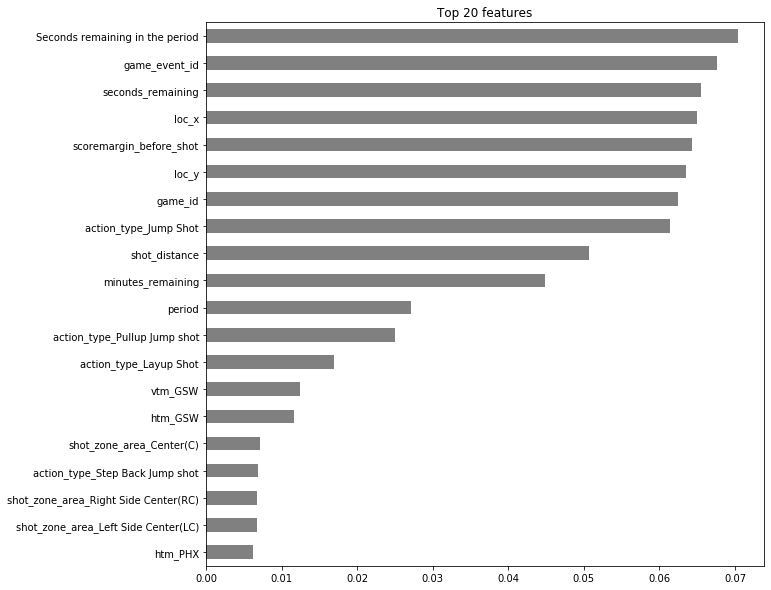

In [228]:
# Get feature importances
encoder = pipeline.named_steps['ordinalencoder']
tree = pipeline.named_steps['randomforestclassifier']
feature_names = encoder.transform(X_val).columns
importances = pd.Series(tree.feature_importances_, feature_names)

# Plot feature importances
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [ ]:
#trees don't extrapolate as opposed to linear
#for time series, be careful of long-term trends

This Sprint Challenge has two parts. To demonstrate mastery on each part, do all the required, numbered instructions. To earn a score of "3" for the part, also do the stretch goals.

 Part 1. Prepare to model

### Required

1. **Do train/validate/test split.** Use the 2009-10 season through 2016-17 season to train, the 2017-18 season to validate, and the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your train set has 11081 observations, your validation set has 1168 observations, and your test set has 1709 observations.
2. **Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is the baseline accuracy for the validation set, if you guessed the majority class for every prediction?
3. **Use Ordinal Encoding _or_ One-Hot Encoding,** for the categorical features you select.
4. **Train a Random Forest _or_ Logistic Regression** with the features you select.

### Stretch goals
Engineer at least 4 of these 5 features:

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?
    

Part 2. Evaluate models

### Required
1. Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.)
2. Get your model's **test accuracy.** (One time, at the end.)
3. Get and plot your Random Forest's **feature importances** _or_ your Logistic Regression's **coefficients.**
4. Imagine this is the confusion matrix for a binary classification model. **Calculate accuracy, precision, and recall for this confusion matrix:**

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>


### Stretch goals
- Calculate F1 score for the provided, imaginary confusion matrix.
- Plot a real confusion matrix for your basketball model, with row and column labels.
- Print the classification report for your model.

In [229]:
#accuracy = 
36/(36+58)

0.3829787234042553

In [230]:
#precision= 
36/(36+85)

0.2975206611570248

In [231]:
#recall =
85/(85+8)

0.9139784946236559